In [ ]:
!pip install pandas 
!pip install openpyxl
#для запуска необходима установкла следующих библиотек

In [8]:
main  = r'4.4.1.xlsx'


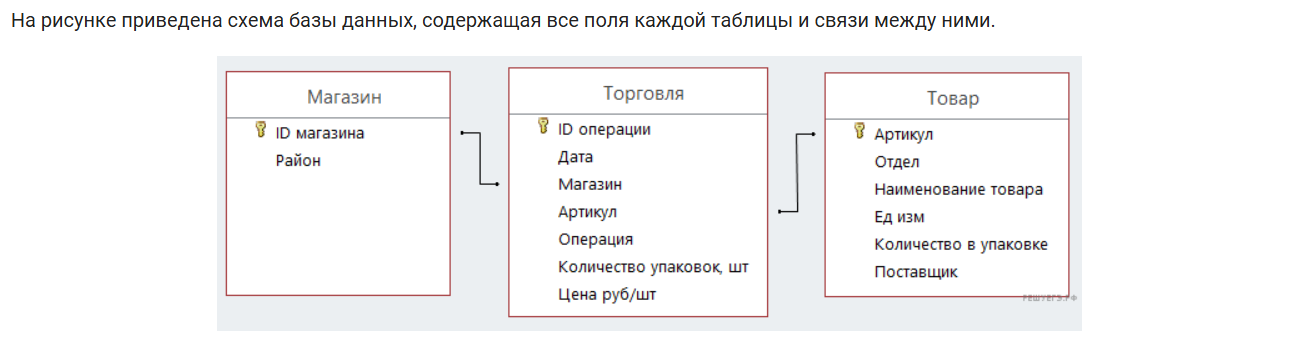
### Используя информацию из приведённой базы данных, определите общую прибыль, полученную за месяц магазинами Центрального района от торговли всеми видами круп.Под прибылью в этой задаче понимается разница между стоимостью продажи и стоимостью поставки товаров.

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
sales = pd.read_excel(main,sheet_name='Торговля')
sales['Дата']=pd.to_datetime(sales['Дата'],dayfirst=True)
products = pd.read_excel(main,sheet_name='Товар')
shops = pd.read_excel(main,sheet_name='Магазин')
#считываем каждый лист в отдельный датафрейм и даем им осмысленное название. В продажах преобрахуем столбец дата в тип дата,
#с учетом того что первым идет день

In [34]:
#перед соединением фильтруем датафреймы 
shops = shops[shops['Район']=='Центральный']
products = products[(products['Наименование товара'].str.startswith('Крупа'))|(products['Наименование товара'].str.startswith('крупа'))]

sales.rename({'Магазин':'ID'},axis=1,inplace = True)
shops.rename({"ID магазина":"ID"},axis=1,inplace=True)
#соединяем датафреймы 
sales = sales.merge(shops,how='inner', on ='ID').merge(products,how='inner',on='Артикул')

In [35]:

sales.rename(columns={
    'ID операции': 'ID_Operation',
    'Дата': 'Date',
    'ID': 'ID',
    'Артикул': 'Article',
    'Операция': 'Operation',
    'Количество\nупаковок, шт': 'Quantity_Packages',
    'Цена руб/шт': 'Price_per_unit',
    'Район': 'District',
    'Отдел': 'Department',
    'Наименование товара': 'Product_Name',
    'Поставщик': 'Supplier'
}, inplace=True)
# также удалим ненужные 
sales.drop(columns=['Ед изм', 'Количество\nв упаковке'], inplace=True)
sales.info()
#смотрим интересующие нас данные так как нам нужно общее количество выручки посчитать,
#  нужно создать колонку с перемноженным количеством на цену за штуку, если ма планируем загружать датафрейм в базу данных , можно переименовать колонки 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1434 entries, 0 to 1433
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID
операции        1434 non-null   int64         
 1   Date               1434 non-null   datetime64[ns]
 2   ID                 1434 non-null   object        
 3   Article            1434 non-null   int64         
 4   Operation          1434 non-null   object        
 5   Quantity_Packages  1434 non-null   int64         
 6   Price_per_unit     1434 non-null   int64         
 7   District           1434 non-null   object        
 8   Department         1434 non-null   object        
 9   Product_Name       1434 non-null   object        
 10  Supplier           1434 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 123.4+ KB


In [37]:
#назовем колонку total_price
sales['Total_price']=sales['Price_per_unit']*sales['Quantity_Packages']

In [38]:
sales.head()

,ID\nоперации,Date,ID,Article,Operation,Quantity_Packages,Price_per_unit,District,Department,Product_Name,Supplier,Total_price
0,235,2021-06-01,М08,46,Поставка,200,49,Центральный,Бакалея,Крупа манная,Мелькомбинат,9800
1,295,2021-06-01,М10,34,Продажа,36,94,Центральный,Бакалея,Крупа гречневая ядрица,Продбаза,3384
2,307,2021-06-01,М10,56,Продажа,28,97,Центральный,Бакалея,Крупа пшено,Продбаза,2716
3,354,2021-06-01,М12,34,Продажа,330,92,Центральный,Бакалея,Крупа гречневая ядрица,Продбаза,30360
4,358,2021-06-01,М12,46,Продажа,238,47,Центральный,Бакалея,Крупа манная,Мелькомбинат,11186


In [39]:
#сохраним датафрейм в файл, для загрузки в базу данных , либо для аналитиков 
sales.to_csv('output.csv')

In [42]:
#сгруппируем полученный датафрейм по номеру месяца,
#  в данном случае у меня только один месяц, но было бы нескольно можно было бы отследить динамику по месяцам
#узнаем итоговую сумму продаж по магазинам в центральном районе по продажам крупы, можно было бы не фильтровать и разбить группировку по округам и товарам
# но я делаю учет на то что у нас может быть большой массив данных. чтобы не перегружать систему
df = sales.groupby([sales['Date'].dt.month,sales.Operation]).agg({'Total_price':'sum'})
df

Total_price
Date Operation             
6    Поставка       4973020
     Продажа        5828606

In [ ]:
total_supply = df.loc[(slice(None), 'Поставка'), 'Total_price'].sum()
total_sales = df.loc[(slice(None), 'Продажа'), 'Total_price'].sum()

#получаем результат чистого дохода от общей цены продаж вычли цену поставки 
diff = total_sales - total_supply
diff

np.int64(855586)

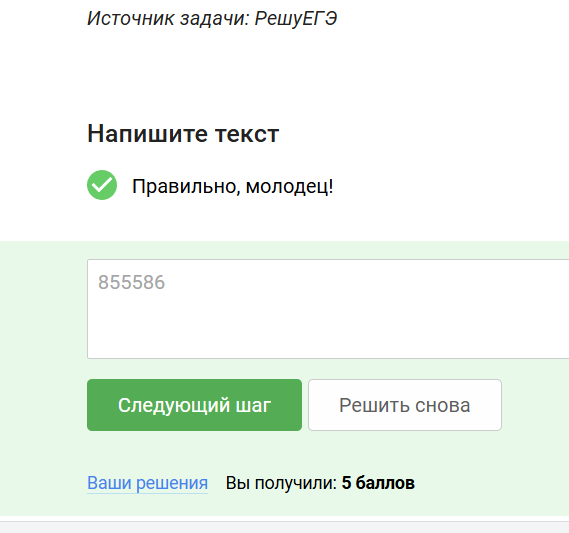
